# Social Sent Lexicon Exploration
This notebook contains data exploration and descriptive statistics regarding
the social sent lexicons. It also shows semantic orientation distribution 
of single words throughout the lexicons. 

This content was used to become familiar with the Social Sent lexicons.
It was not directly used in the research paper. 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from nltk import word_tokenize

from social_sent_helpers import list_lexicons, read_lexicon, games_list, sports_list, read_all_lexicons

from scipy.stats import ks_2samp

In [2]:
from bokeh.plotting import ColumnDataSource, figure, output_notebook, show
from bokeh.models.widgets import DataTable
from bokeh.models import TableColumn
from bokeh.layouts import Column, Row

output_notebook()

Loading BokehJS ...

<BarContainer object of 67 artists>

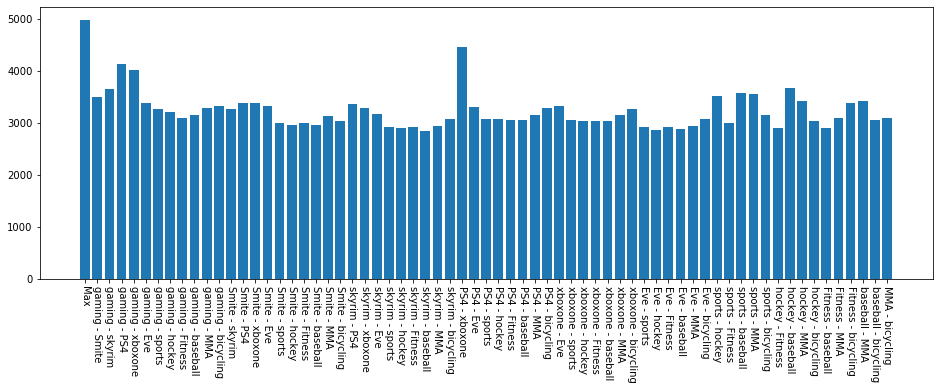

In [4]:
lex_words = {}
names = list(list_lexicons().sample(5))
names = games_list + sports_list

for name in names:    
    lex = read_lexicon(name)
    lex_words[name] = list(lex.word)
    
labels = ["Max"]
values = [max(len(ls) for ls in lex_words.values())]
for name in tqdm(names):
    for name2 in names[names.index(name) + 1:]:
        intersection = set(lex_words[name]).intersection(set(lex_words[name2]))
        labels.append(name + " - " + name2)
        values.append(len(intersection))
        
plt.figure(figsize=(16, 5))
plt.xticks(rotation=360 - 90)
plt.bar(labels, values)

In [5]:
lexicons = [read_lexicon(name) for name in tqdm(list_lexicons())]

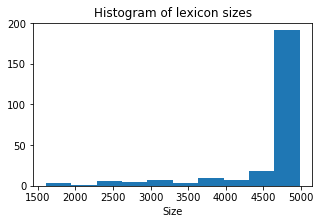

In [6]:
plt.figure(figsize=(5, 3))
plt.title("Histogram of lexicon sizes")
plt.xlabel("Size")
plt.hist([len(lex) for lex in tqdm(lexicons)])
plt.show()

In [7]:
word_occurrences = Counter()
for name in tqdm(list_lexicons()):
    for word in read_lexicon(name).word:
        word_occurrences[word] += 1

In [8]:
se = pd.Series(word_occurrences)

In [9]:
n_words_in_every_lex = len(se[se == 250])

In [10]:
len(se[se > 200])

2204

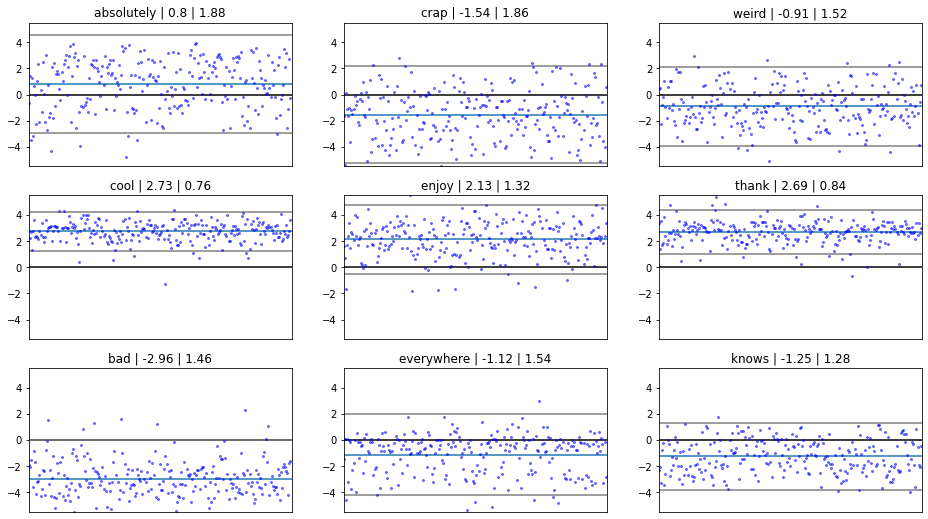

In [11]:
def configure_plot():
    plt.ylim((-5.5,5.5))
    plt.xlim((0, 250))
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    plt.axhline(0, color="black")

nrows = 3
ncols = 3
plt.figure(figsize=(16, 3*nrows))

#for i, word in enumerate(tqdm(se[se == 250].sample(nrows * ncols).index)):
for i, word in enumerate(tqdm(["absolutely","crap","weird","cool","enjoy","thank","bad","everywhere","knows"])):
    plt.subplot(nrows, ncols, i + 1)
    word_sos = [lexicon.set_index("word").so[word] for lexicon in lexicons]
    configure_plot()
    m = np.around(np.mean(word_sos), 2)
    s = np.around(np.std(word_sos), 2)
    plt.title("{} | {} | {}".format(word, m, s))
    plt.axhline(m)
    plt.axhline(m + 2*s, color="grey")
    plt.axhline(m - 2*s, color="grey")
    plt.plot(word_sos, "bo", markersize=2, alpha=0.5)

plt.show()

In [12]:
def word_so_analysis(word):
    lex_scores = [(i, lex_name, lexicon.set_index("word").so[word]) 
                  for i, (lex_name, lexicon) in enumerate(zip(list_lexicons(), lexicons)) 
                  if word in lexicon.word.values]
    len(lex_scores)
    data_source = ColumnDataSource(pd.DataFrame(lex_scores, columns=["index", "lex_name", "so"]))

    so_scores = [so for i, _, so in lex_scores]


    p = figure(plot_width=600, plot_height=400, tooltips="@lex_name", 
               title="{} (in {} lexicons) - SO Scores Mean: {} Std: {}".format(
                   word, len(lex_scores), np.around(np.mean(so_scores), 2), np.around(np.std(so_scores), 2)), 
               tools="pan,lasso_select,box_select", x_axis_label="Lexicon Index", y_axis_label="Semantic Orientation")
    p.circle('index', 'so', size=5, source=data_source)
    show(p)
    
word_so_analysis("everywhere")

In [13]:
res = []
for i, word in enumerate(tqdm(se[se == 250].index)):
    word_sos = [lexicon.set_index("word").so[word] for lexicon in lexicons]
    res.append([word, np.around(np.mean(word_sos), 2), np.around(np.std(word_sos), 2)])
result_df = pd.DataFrame(res, columns=["word", "mean", "std"])

data_source = ColumnDataSource(result_df)

p = figure(plot_width=600, plot_height=400, tooltips="@word", 
           title="Mean so and so standard deviation", tools="pan,lasso_select,box_select",
           x_axis_label="Mean", y_axis_label="Standard Deviation"
          )
p.circle('mean', 'std', size=5, source=data_source)

data_table = DataTable(source = data_source, height=200, width=300,
                       columns=[
                           TableColumn(field = 'word', title = 'Word'),
                           TableColumn(field = 'mean', title = 'Mean'),
                           TableColumn(field = 'std', title = 'Standard Deviation')
                       ])
show(Row(p, data_table))

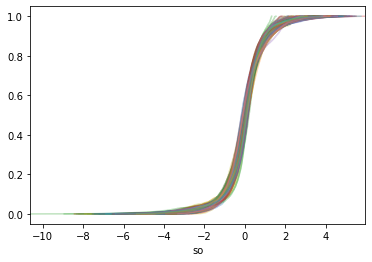

In [17]:
def lexicon_cdf(lex, norm=False):
    if isinstance(lex, list):
        [lexicon_cdf(l, norm) for l in lex]
        return
    lex = lex.sort_values("so")
    lex["part"] = np.linspace(0, 1, len(lex)) # Cumsum
    if norm:
        plt.plot(np.interp(lex.so, (lex.so.min(), lex.so.max()), (0, 1)), lex.part)
    else:
        lex.set_index("so")["part"].plot(alpha=0.3)
    
lexicon_cdf(read_all_lexicons())

In [19]:
ks_values = np.zeros((len(lexicons), len(lexicons)))
print(ks_values.shape)

lex_names = list_lexicons()

for i, (l1, name1) in enumerate(zip(tqdm(lexicons), lex_names)):
    for j, (l2, name2) in enumerate(zip(tqdm(lexicons[i:], leave=False), lex_names[i:])):
        if name1 != name2:
            d, p = ks_2samp(l1.so, l2.so)
            ks_values[i, j+i] = d
            ks_values[j+i, i] = d
            
assert ks_values.diagonal().std() == 0 and ks_values.diagonal().mean() == 0

(250, 250)


(array([ 2784., 15804., 18266., 12594.,  7254.,  3652.,  1524.,   466.,
          132.,    24.]),
 array([0.        , 0.02564991, 0.05129982, 0.07694972, 0.10259963,
        0.12824954, 0.15389945, 0.17954935, 0.20519926, 0.23084917,
        0.25649908]),
 <a list of 10 Patch objects>)

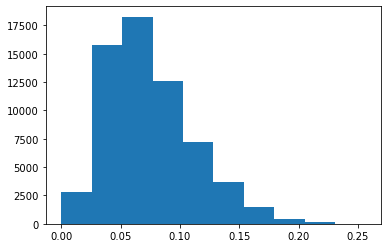

In [20]:
plt.hist(ks_values.flatten())